# Multiple Linear Regression For STLE Prediction

In [1]:
import intro_Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("../data/umich.csv", index_col=0)
data_full = data.copy()
data = data.drop(['H','W'],axis=1)
data = data[data['Run'] != 'R16']

In [4]:
px1 = data_full['px1'][0]
px2 = data_full['px2'][0]
px3 = data_full['px3'][0]
px4 = data_full['px4'][0]
px5 = data_full['px5'][0]

location_list = [px1,px2,px3,px4,px5]

Run 16 (R16) has 479 missing values for the true STLE location. For now, we can exclude this run, and deal with the missing value later.

In [5]:
runs = data['Run'].unique()

In [6]:
variables = {}

# Loop through a range of values
for i in runs:
    # Create a new variable name
    variable_name = f"{i}"
    
    # Create a new variable value
    variable_value = data[data['Run']==i]
    
    # Assign the variable value to the variable name in the dictionary
    variables[variable_name] = variable_value.reset_index(drop=True)

for variable_name, variable_value in variables.items():
    globals()[variable_name] = variable_value

In [7]:
def impute_cols(data_frame):
    X = data_frame[['p1','p2','p3','p4','p5']]
    y = data_frame['x1']
    return X,y

In [8]:
df_list = [R0, R1, R2, R3, R4, R5, R6, R7, R8, R9, R10, R11,
           R12, R13, R14, R15, R17, R18, R19, R20, R21,
           R22, R23, R24, R25, R26, R27, R28, R29, R30, R31,
           R32, R33, R34, R35, R36, R37] # Note: R16 is dropped because of NaN values.

In [9]:
from sklearn.linear_model import LinearRegression

train_average_score = []
test_average_score = []
train_average_MSE = []
test_average_MSE = []

for i in df_list:
    X,y = impute_cols(i)
    lin_reg = LinearRegression()
    train_scores, test_scores, train_mse, test_mse = intro_Data.do_Kfold(lin_reg,X.values,y.values,10)
    train_average_score.append(np.mean(train_scores))
    test_average_score.append(np.mean(test_scores))
    train_average_MSE.append(np.mean(train_mse))
    test_average_MSE.append(np.mean(test_mse))

In [10]:
lin_reg_summary = pd.DataFrame(data = {'Train Avg. Score Per Run':train_average_score,
                                             'Test Avg. Score Per Run':test_average_score,
                                             'Train Avg. MSE Per Run': train_average_MSE,
                                              'Test Avg. MSE Per Run':test_average_MSE},
                              index = data['Run'].unique())

In [11]:
lin_reg_summary.sort_values(by='Test Avg. Score Per Run').head(5)

,Train Avg. Score Per Run,Test Avg. Score Per Run,Train Avg. MSE Per Run,Test Avg. MSE Per Run
R17,0.703326,0.702952,62.411917,62.461616
R15,0.723662,0.723305,98.025739,98.107831
R14,0.882368,0.882237,101.255781,101.317549
R13,0.916928,0.916744,64.392961,64.436231
R30,0.919645,0.919594,35.034596,35.053685


In [12]:
lin_reg_summary.sort_values(by='Test Avg. Score Per Run').tail(5)

,Train Avg. Score Per Run,Test Avg. Score Per Run,Train Avg. MSE Per Run,Test Avg. MSE Per Run
R7,0.995292,0.995289,30.650794,30.666057
R22,0.995685,0.995681,30.495562,30.515243
R3,0.996225,0.996222,19.167408,19.174944
R1,0.997108,0.997105,20.733461,20.743083
R0,0.997687,0.997685,14.075059,14.084658


In [13]:
lin_reg_summary.describe().iloc[1,:]

Train Avg. Score Per Run     0.959718
Test Avg. Score Per Run      0.959668
Train Avg. MSE Per Run      47.403656
Test Avg. MSE Per Run       47.430324
Name: mean, dtype: float64

---

# Single TTS On R17

- Since R17 had the lowest average test score, let's see what's going on with a single tts.

In [14]:
from sklearn.model_selection import train_test_split

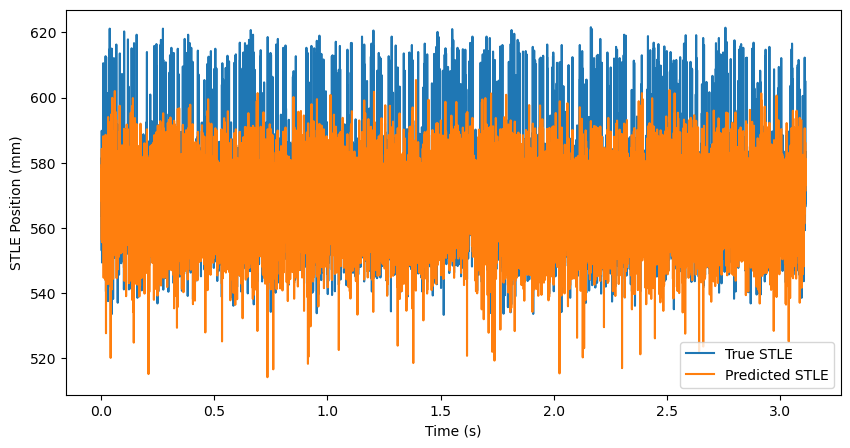

In [15]:
X,y = impute_cols(R17)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(R17.iloc[y_test.index]['time'].sort_values(),y_test,label='True STLE')
plt.plot(R17.iloc[y_test.index]['time'].sort_values(),y_pred,label='Predicted STLE')
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.legend()
plt.show()

In [16]:
print("R^2 Value:", lin_reg.score(X_test, y_test))

R^2 Value: 0.6982712190772883


Overall, the problem with R17 is that our model is generally underestimating the STLE position at a given time. 

---

# Different Methods of TTS (With Time Variable)

- Use R17 again, but this time, dividing training and testing with (0s to 1.5s) and (1.5s to 3s)

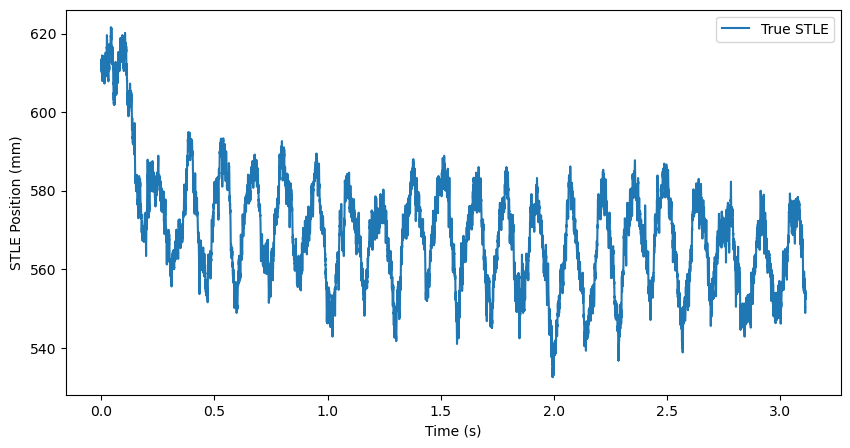

In [17]:
plt.figure(figsize=(10,5))
plt.plot(R17['time'],R17['x1'],label='True STLE')
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.legend()
plt.show()

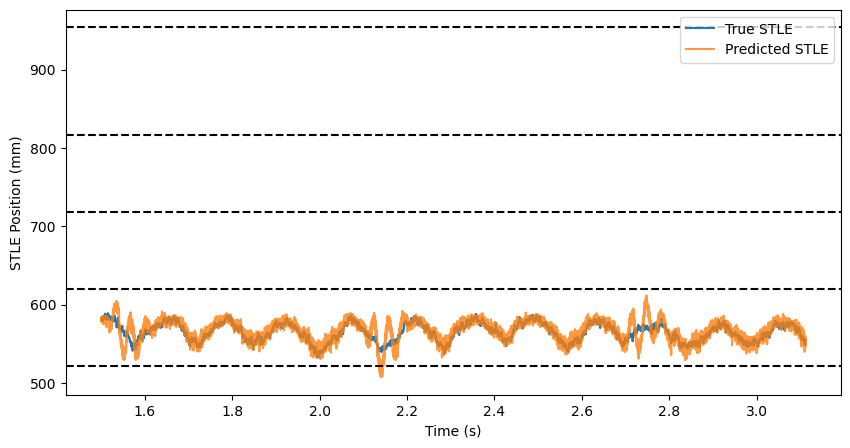

In [87]:
R17_w_time = R17.copy().drop('Run',axis=1)
train = R17_w_time[R17_w_time['time'] < 1.5]
test = R17_w_time[R17_w_time['time'] >= 1.5]

X_train = train.drop(['x1','time'],axis=1)
y_train = train['x1']
X_test = test.drop(['x1','time'],axis=1)
y_test = test['x1']
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)
y_pred_train = lin_reg.predict(X_train)

plt.figure(figsize=(10,5))
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_test,label='True STLE')
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_pred,label='Predicted STLE',alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.legend()

for i in location_list:
    plt.axhline(y=R17_w_time[i].iloc[0], color='black', linestyle='--')

plt.show()

In [88]:
from sklearn.metrics import mean_squared_error

In [89]:
mean_squared_error(y_test, y_pred)

69.02431078519277

In [90]:
lin_reg.coef_

array([-2.71641970e+06, -2.12004874e-03,  2.31836650e-03, -1.35820985e+06,
        1.97972323e-03, -1.31478617e+00, -5.37468660e+00, -2.22344437e+00,
       -1.08376883e+00, -6.24858880e-01])

# Regularized Linear Regression

In [22]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [23]:
X,y = impute_cols(R17)
a_range = np.linspace(15,30,100)
k = 10
ss = StandardScaler()

avg_tr_score=[]
avg_te_score=[]

for a in a_range:
    rid_reg = Ridge(alpha = a)
    train_scores, test_scores, train_mse, test_mse = intro_Data.do_Kfold(rid_reg,X.values,y.values,k,ss)
    avg_tr_score.append(np.mean(train_scores))
    avg_te_score.append(np.mean(test_scores))

In [24]:
idx_max = np.argmax(avg_te_score)

print('Optimal alpha in the range tested: ', a_range[idx_max])
print('Avg. training score at this value: ', avg_tr_score[idx_max])
print('Avg. testing score at this value: ', avg_te_score[idx_max])

Optimal alpha in the range tested:  21.81818181818182
Avg. training score at this value:  0.7033253592510366
Avg. testing score at this value:  0.7029524818943205


## Ridge Regression With a Single TTS & Optimal Alpha (R17)

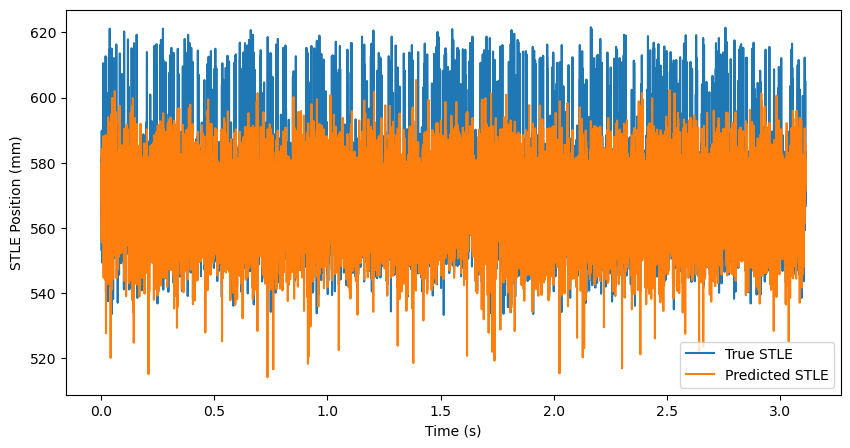

In [25]:
X,y = impute_cols(R17)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rid_reg = Ridge(alpha=21.81818181818182)
rid_reg.fit(X_train,y_train)
y_pred = rid_reg.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(R17.iloc[y_test.index]['time'].sort_values(),y_test,label='True STLE')
plt.plot(R17.iloc[y_test.index]['time'].sort_values(),y_pred,label='Predicted STLE')
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.legend()
plt.show()

Regularized linear regression did not improve our results at all. Now we should turn our attention to different regression algorithms.

# Investigate what's going on with the errors in linear regression

---

**CODE FOR PLOTTING FIGURES**

In [44]:
location_list = ['px1','px2','px3','px4','px5']

/var/folders/p7/nw95jv590mv77sxbkj0f4wqc0000gn/T/ipykernel_3446/1392510018.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,5))


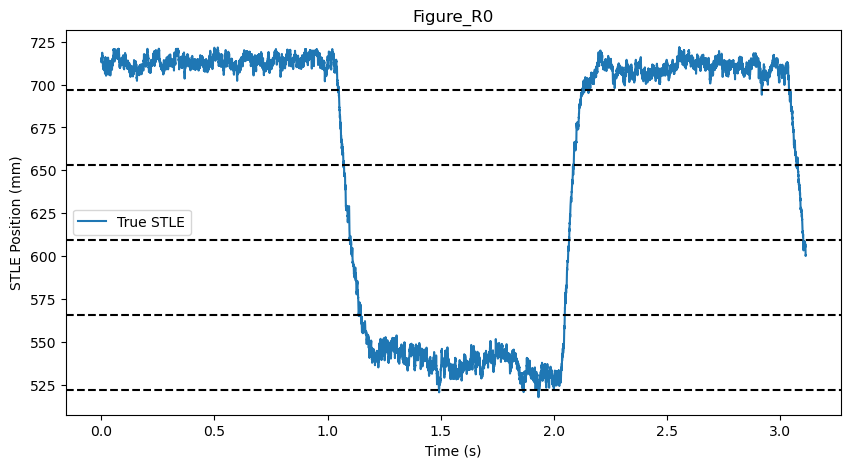

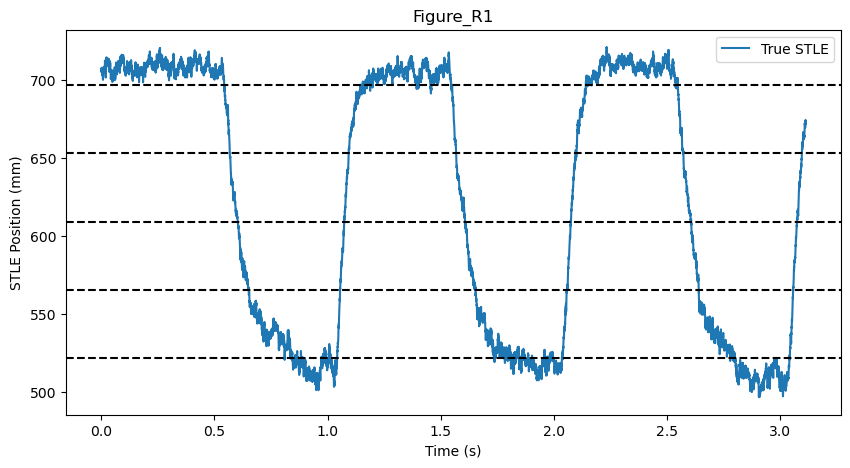

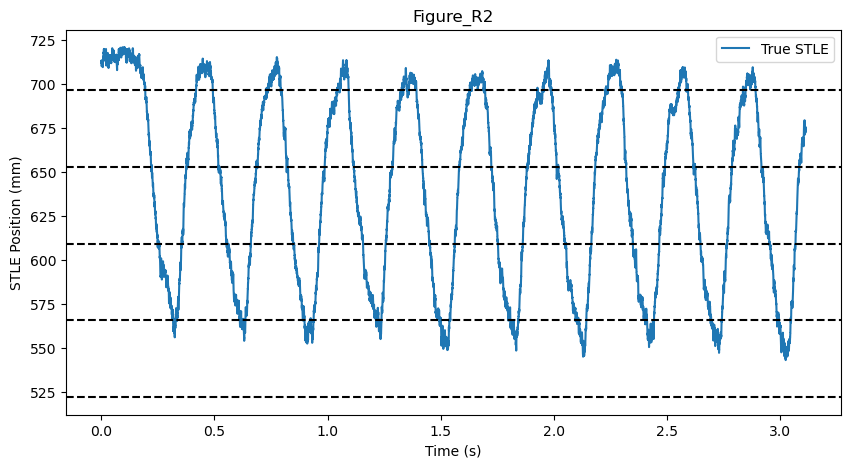

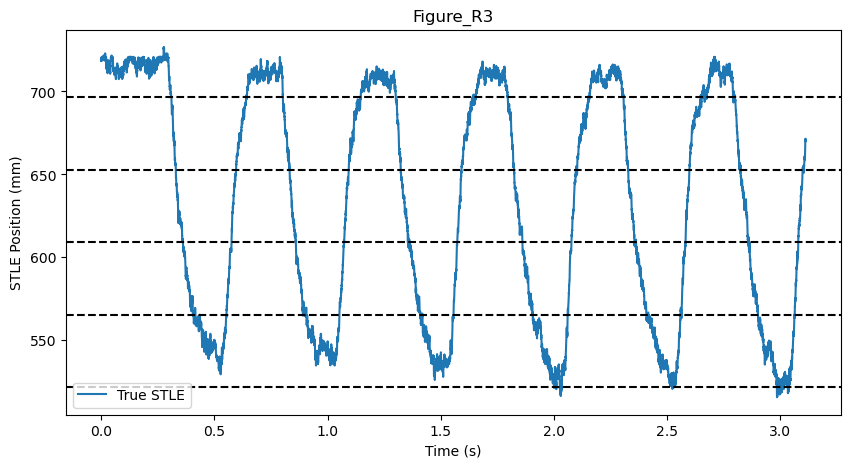

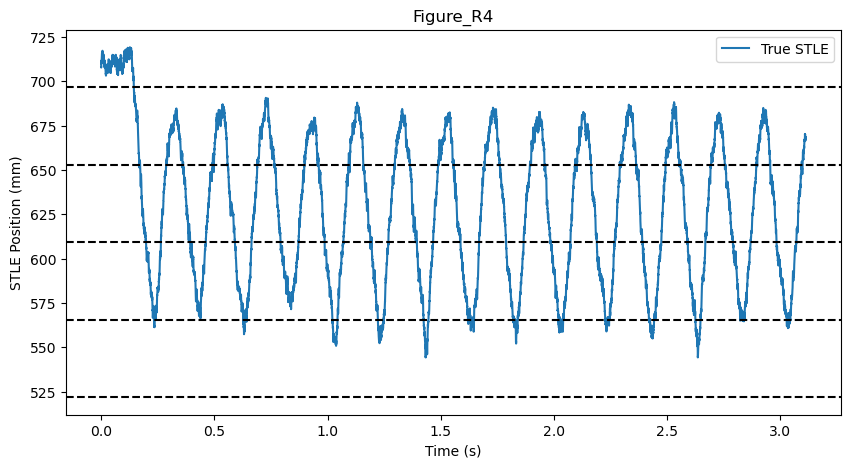

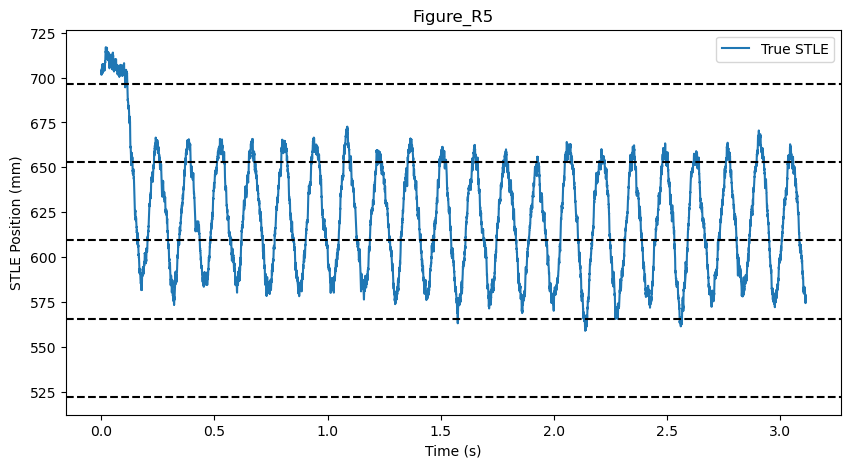

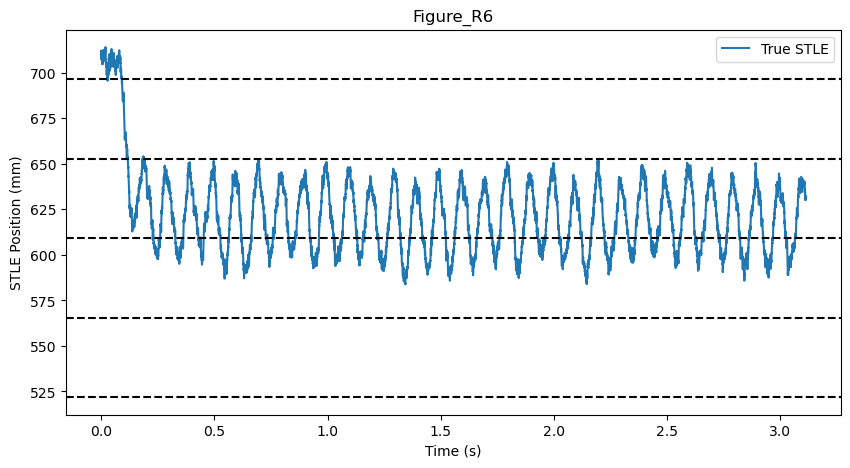

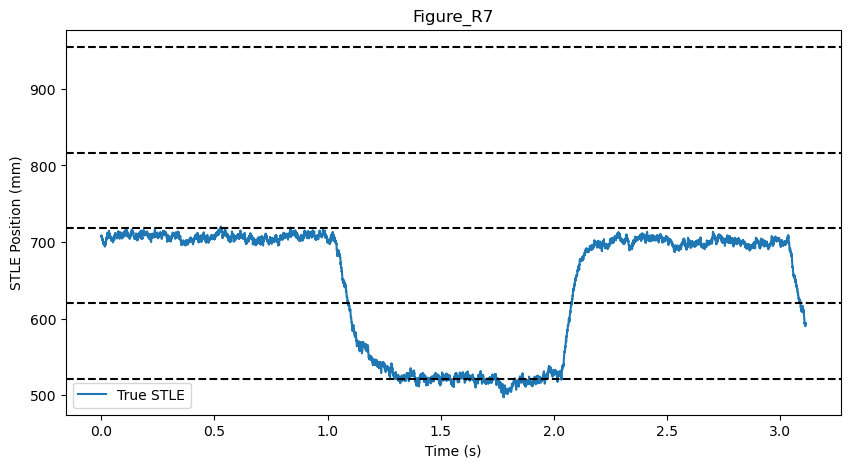

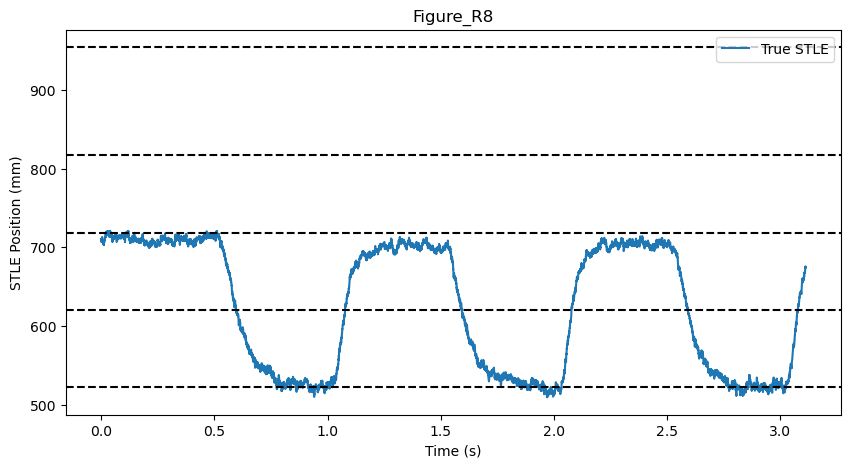

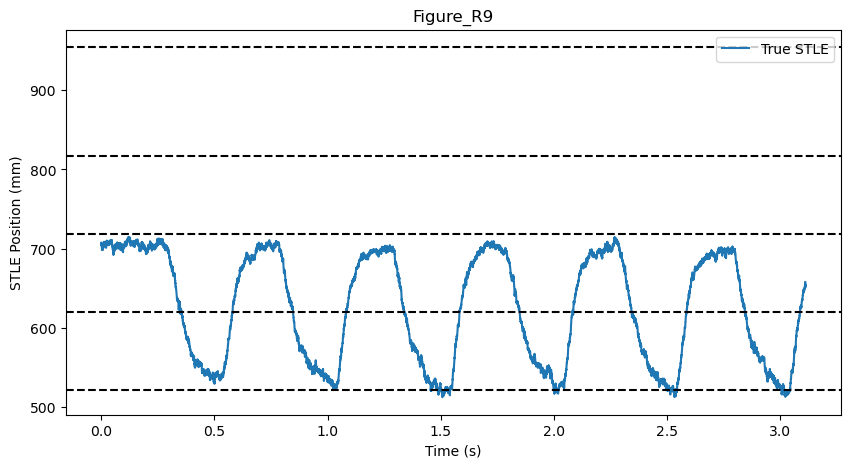

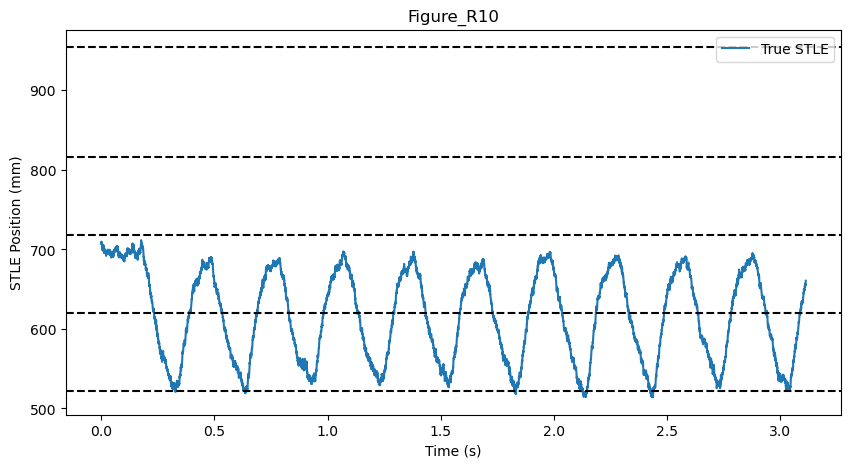

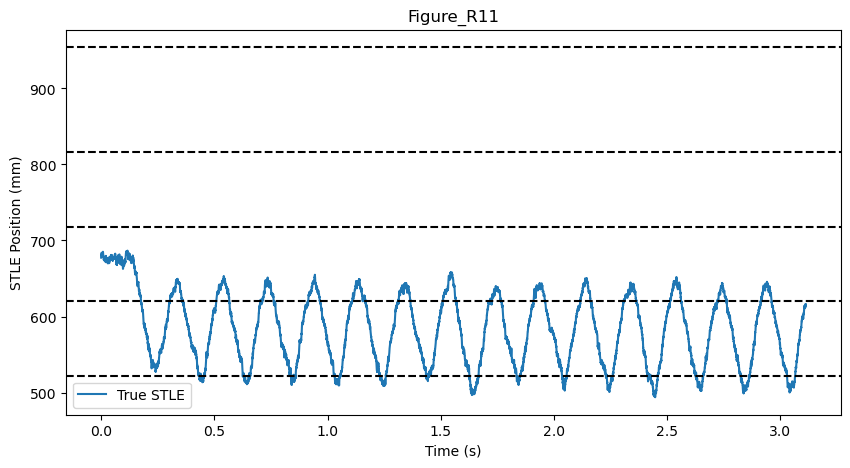

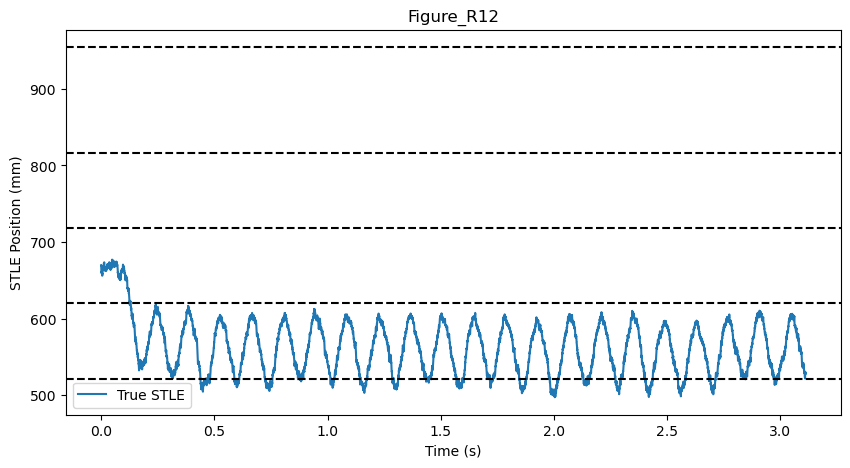

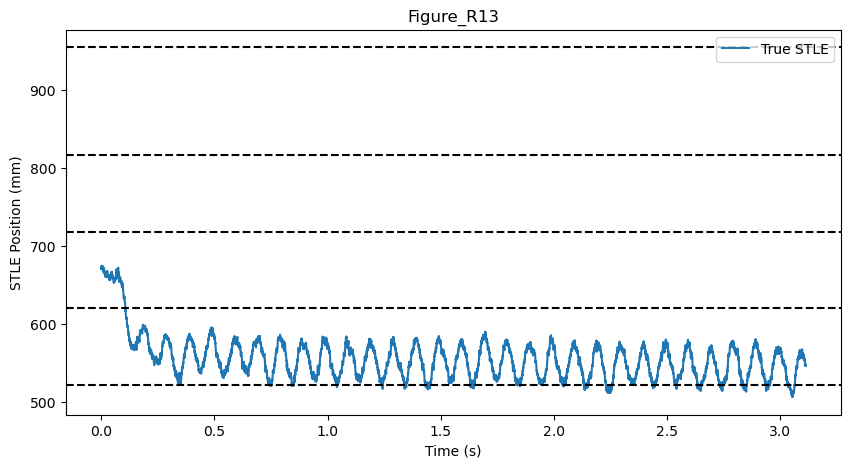

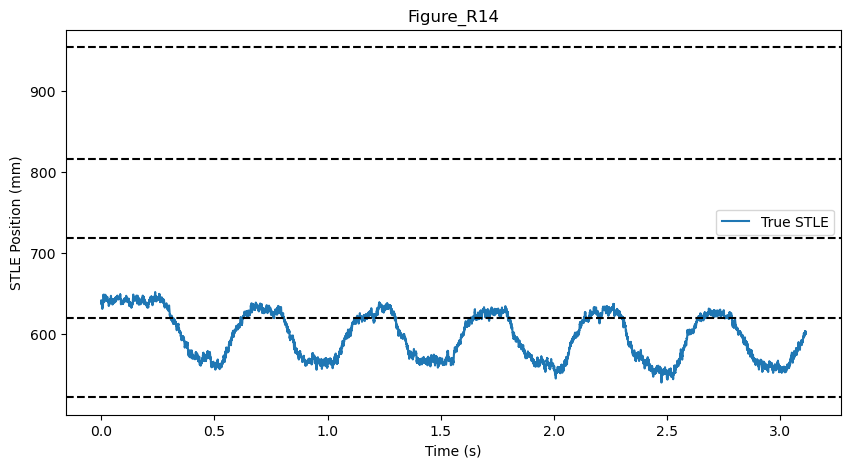

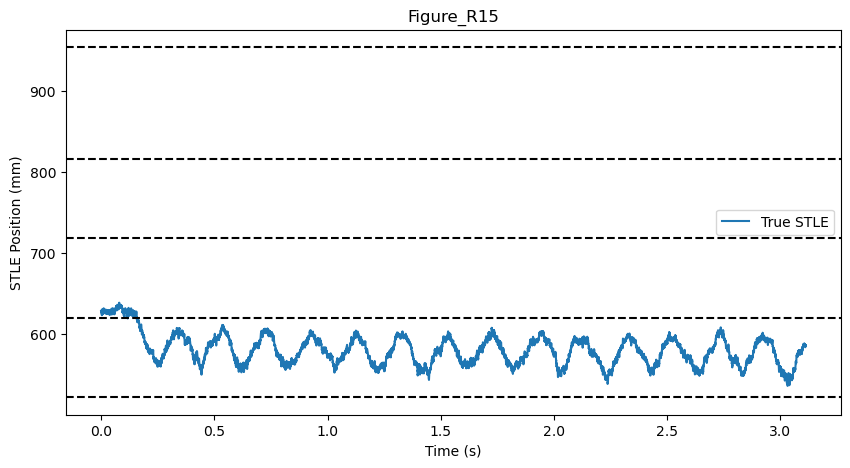

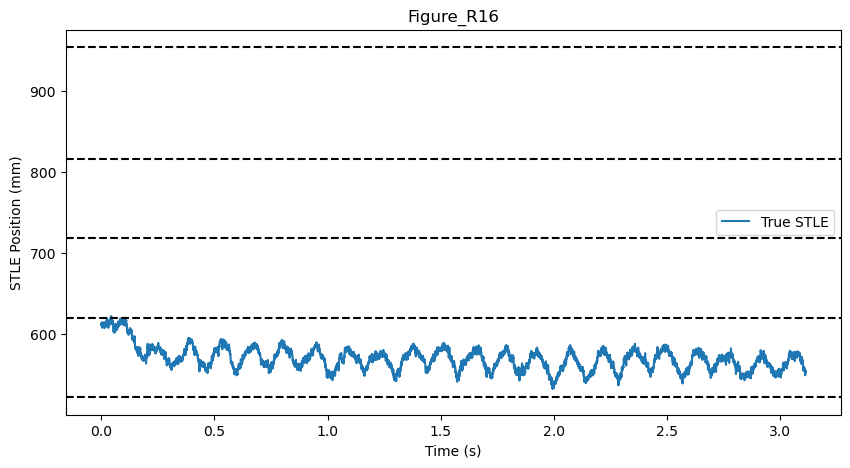

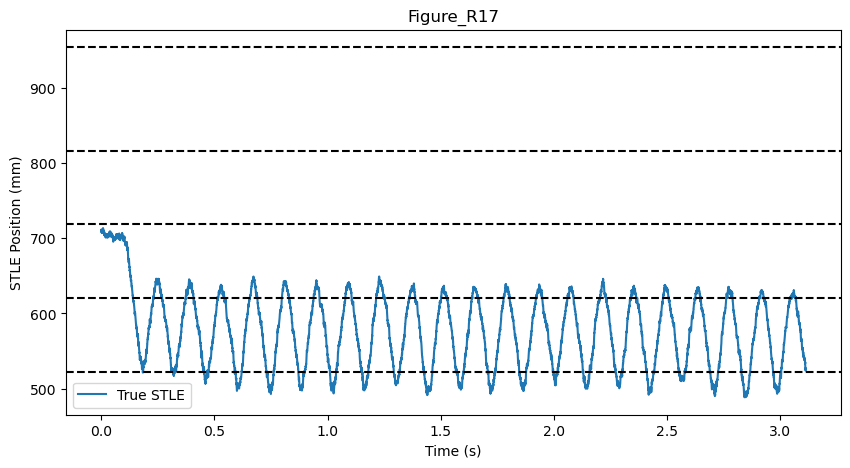

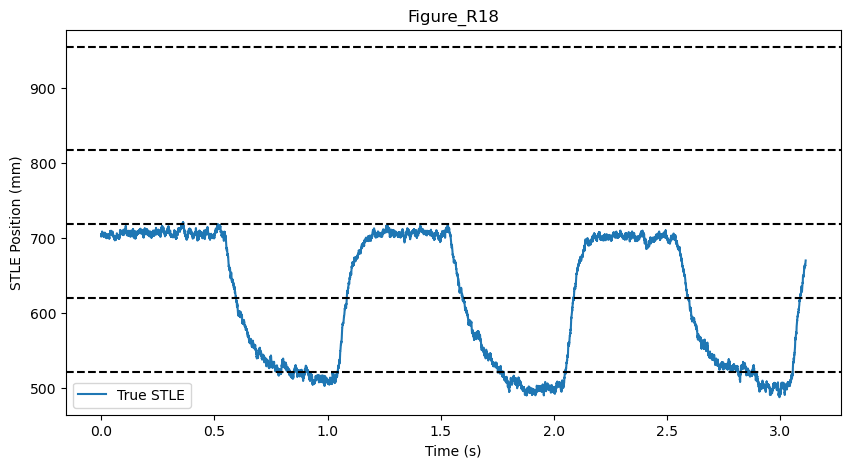

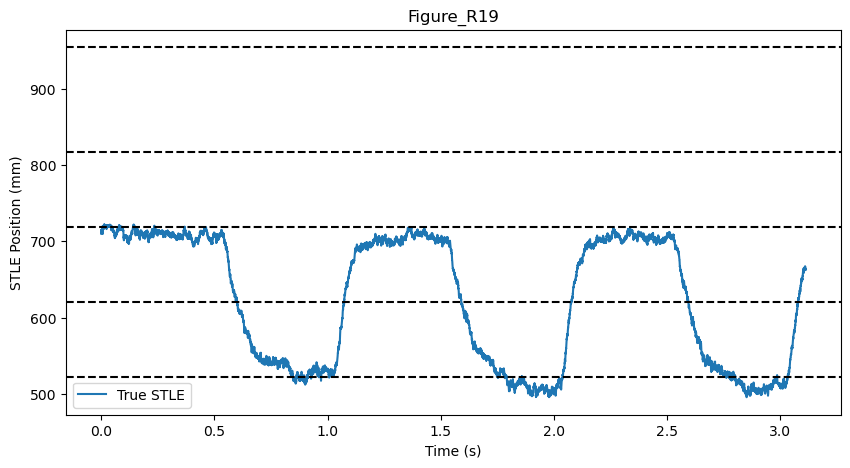

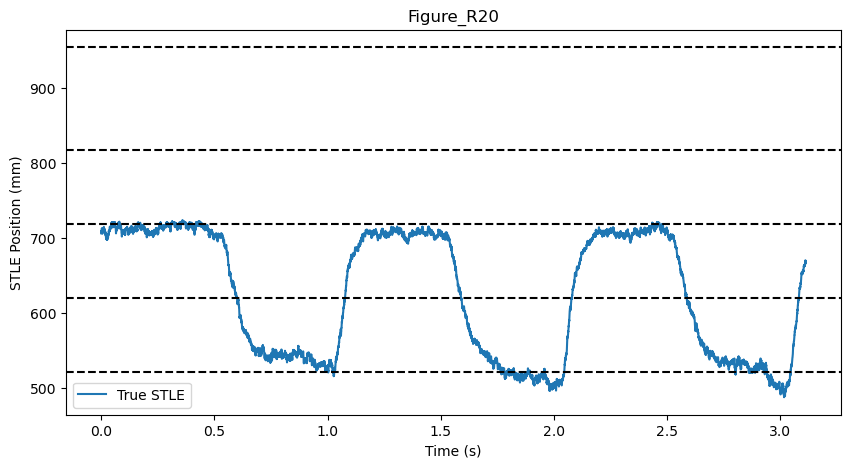

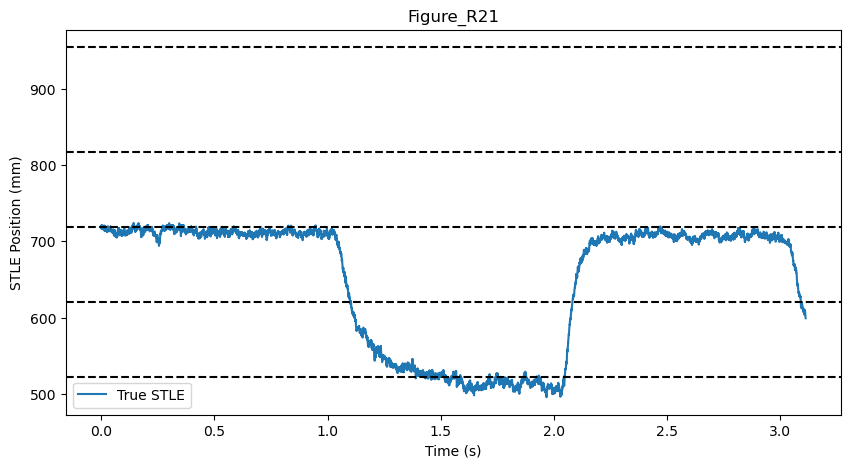

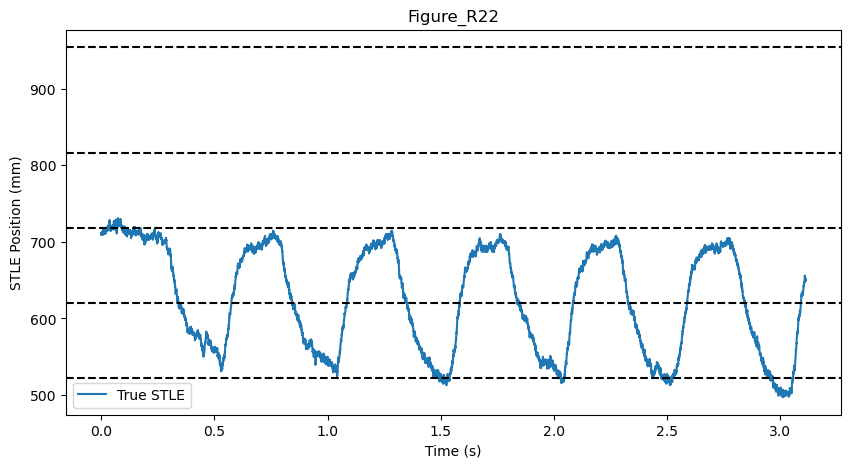

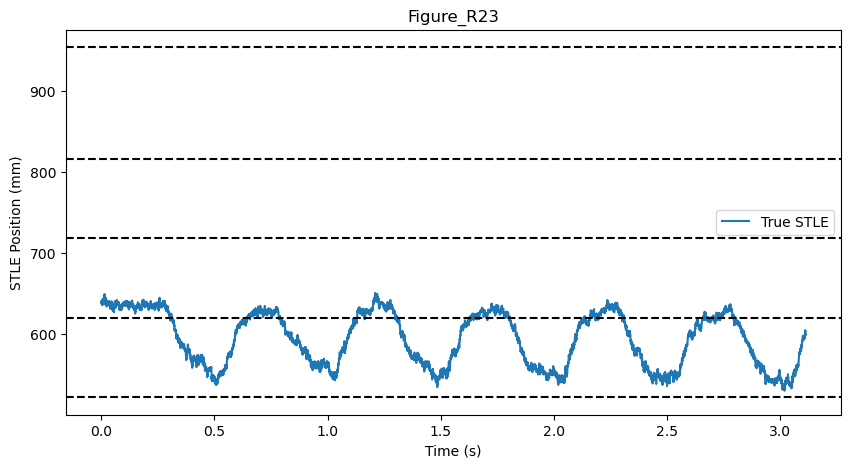

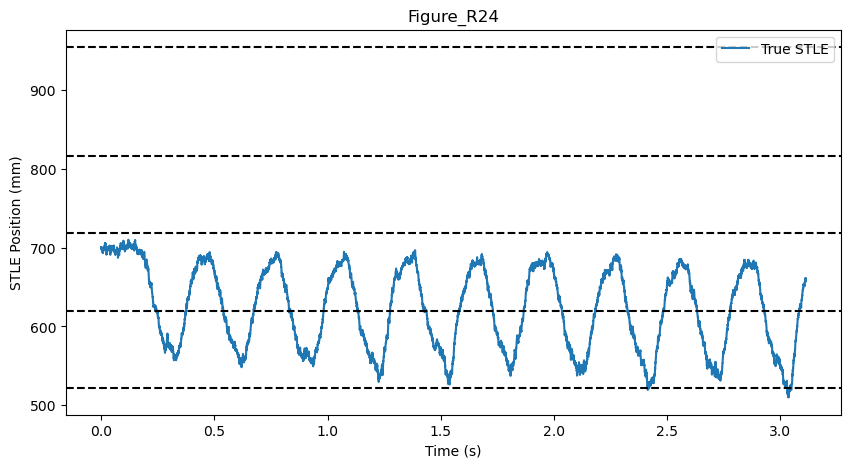

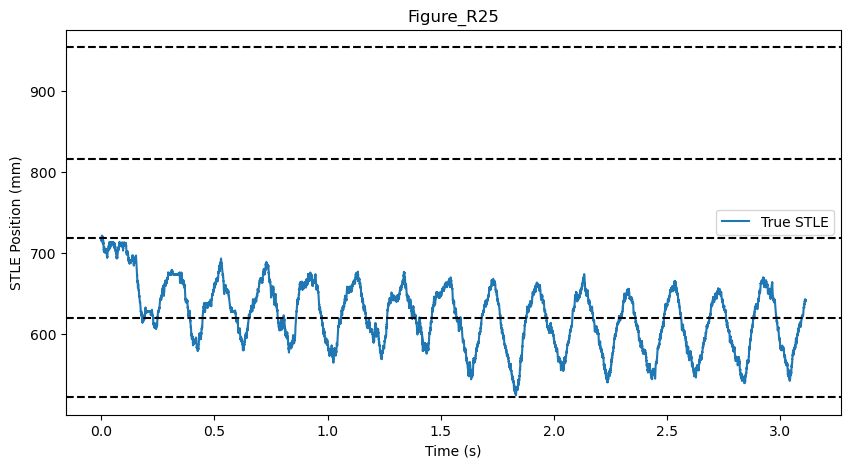

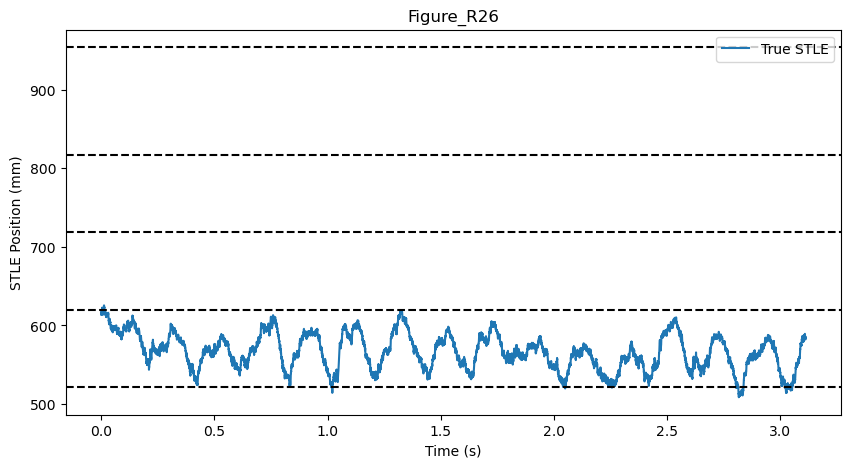

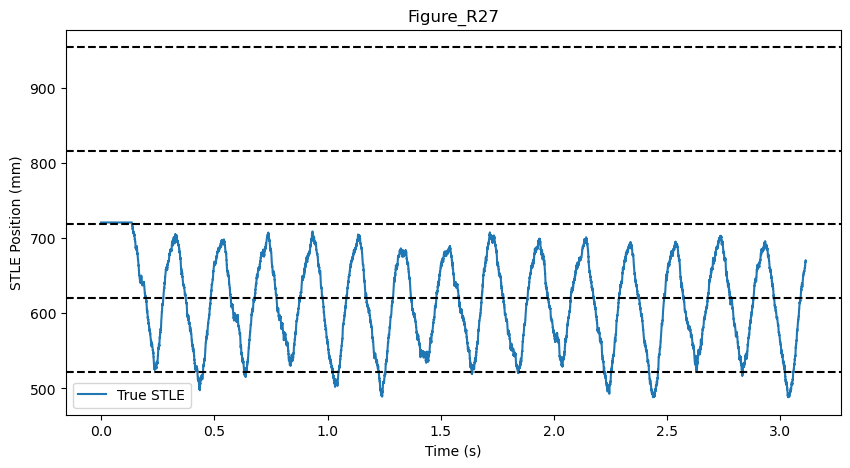

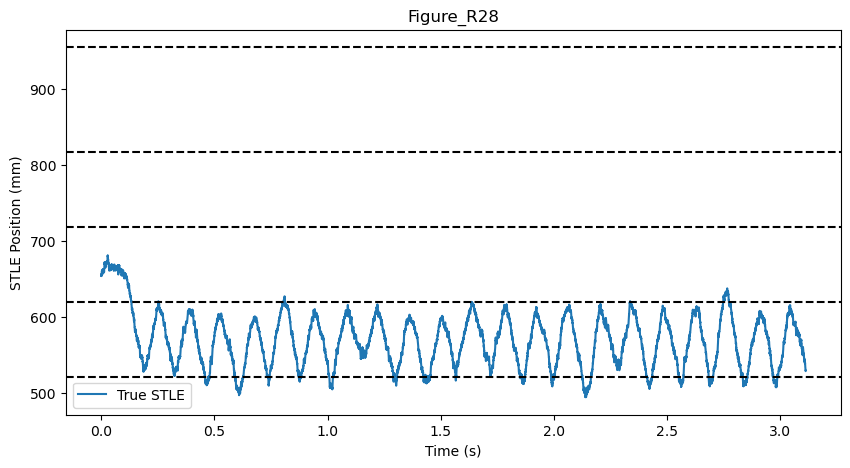

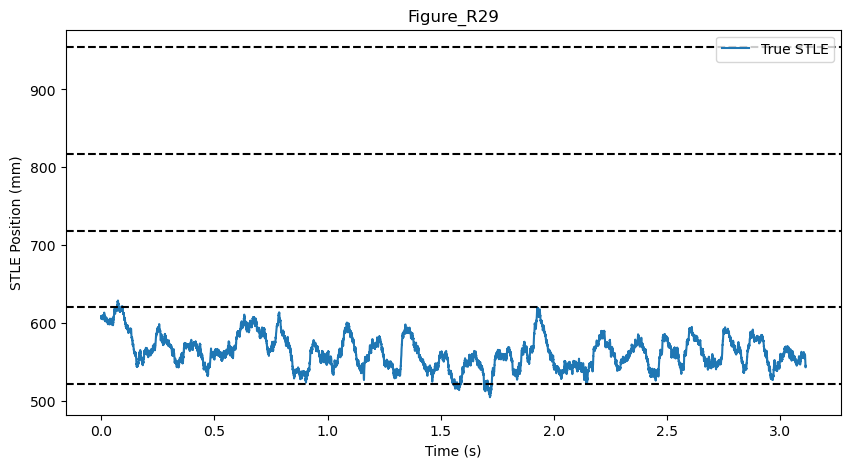

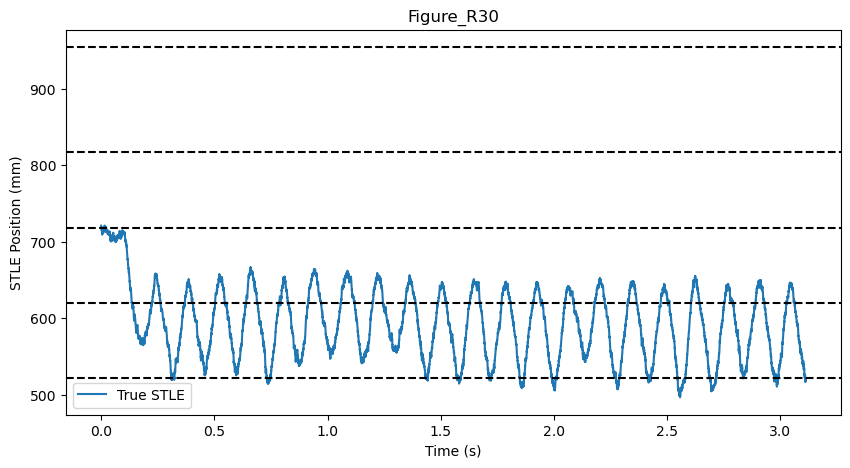

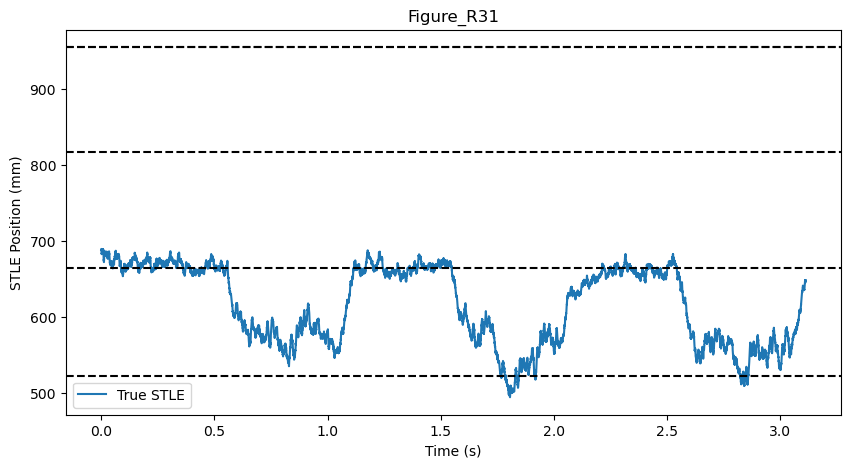

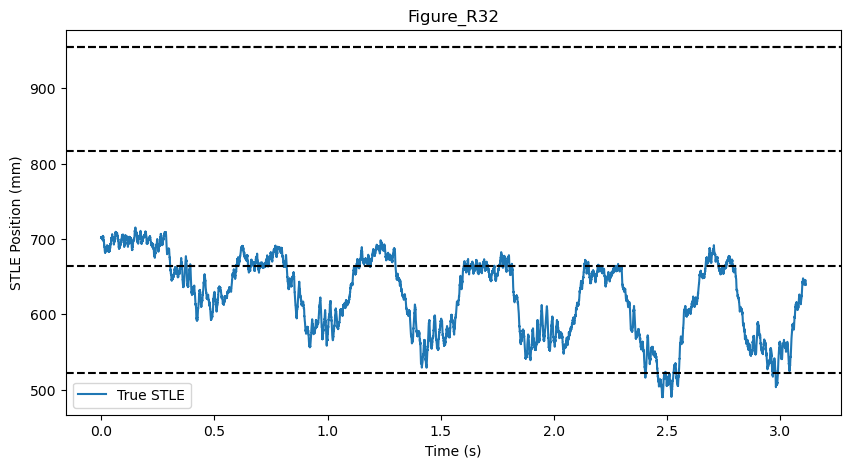

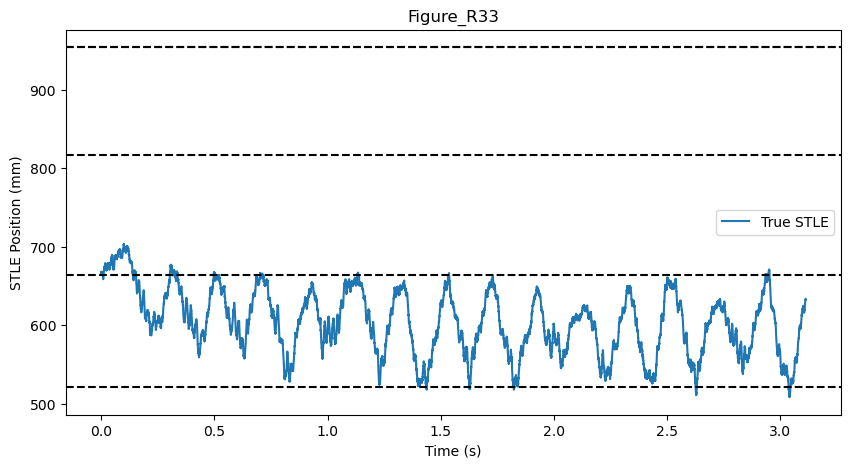

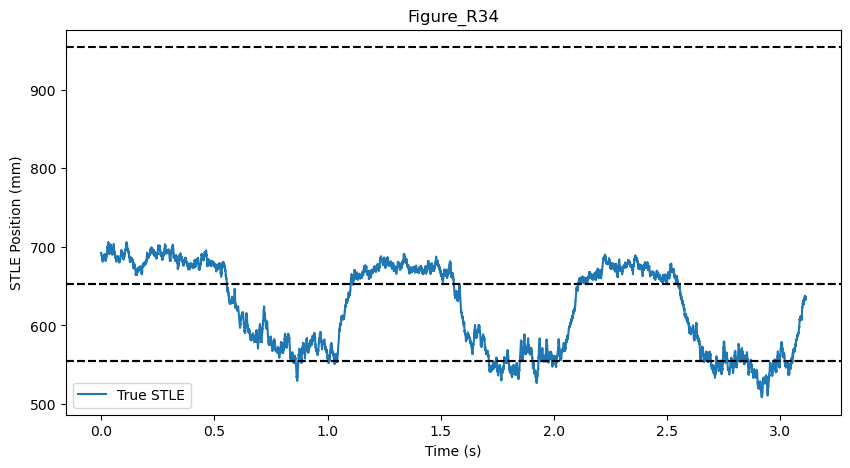

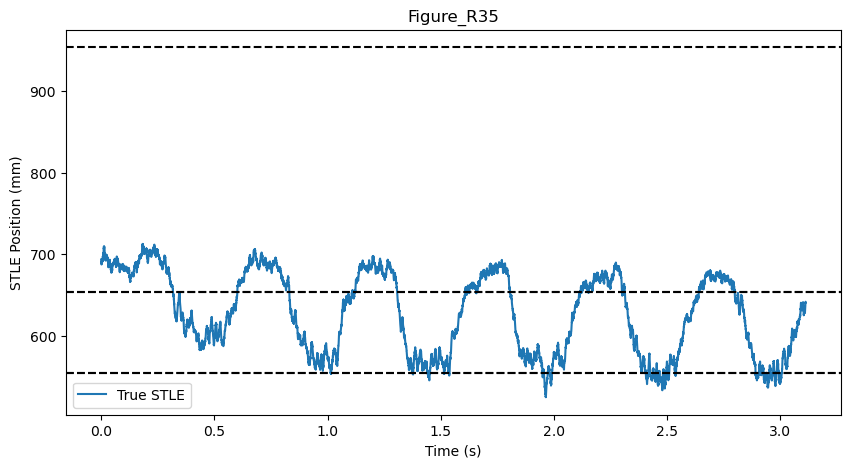

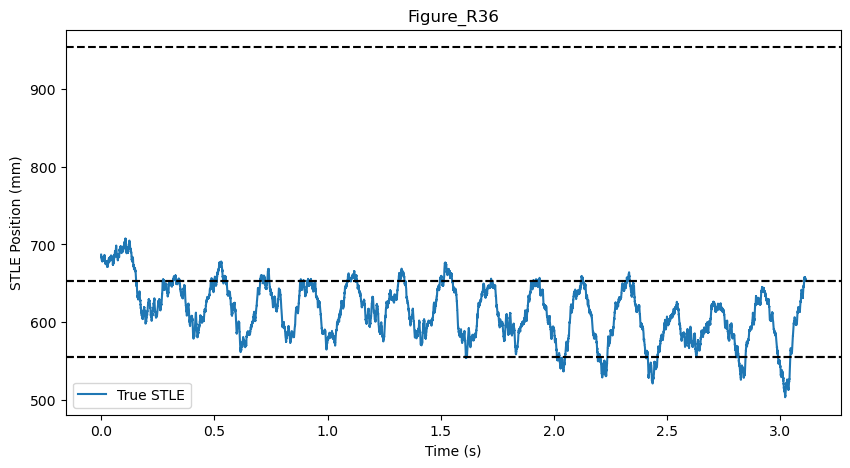

In [46]:
for i in range(len(df_list)):
    fig = plt.figure(figsize=(10,5))
    plt.plot(df_list[i]['time'],df_list[i]['x1'],label='True STLE')
    plt.xlabel('Time (s)')
    plt.ylabel('STLE Position (mm)')
    plt.title(f"Figure_R{i}")
    for j in location_list:
        plt.axhline(y=df_list[i][j].iloc[0], color='black', linestyle='--')
    plt.legend()

---

Take a look at R17 Again (single tts, no time constraint)

We observe that the area with bunch of ocillating errors have high pressure measurements.

We see an weirdly ocillating pressures happening, is this true for the training set as well?

In [47]:
R17_w_time = R14.copy().drop('Run',axis=1)

train = R17_w_time[R17_w_time['time'] < 1.5]
test = R17_w_time[R17_w_time['time'] >= 1.5]

X_train = train.drop('x1',axis=1)
y_train = train['x1']
X_test = test.drop('x1',axis=1)
y_test = test['x1']
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)
y_pred_train = lin_reg.predict(X_train)

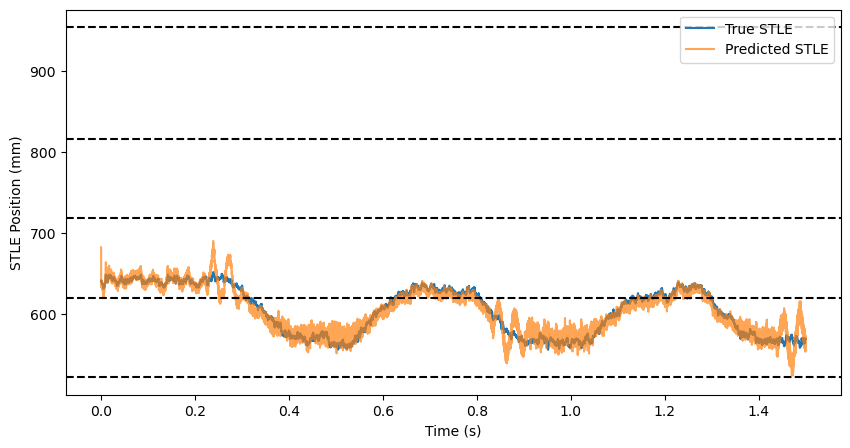

In [55]:
plt.figure(figsize=(10,5))
plt.plot(R17_w_time.iloc[y_train.index]['time'].sort_values(),y_train,label='True STLE')
plt.plot(R17_w_time.iloc[y_train.index]['time'].sort_values(),y_pred_train,label='Predicted STLE',alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.legend()
for i in location_list:
    plt.axhline(y=R17_w_time[i].iloc[0], color='black', linestyle='--')
plt.show()

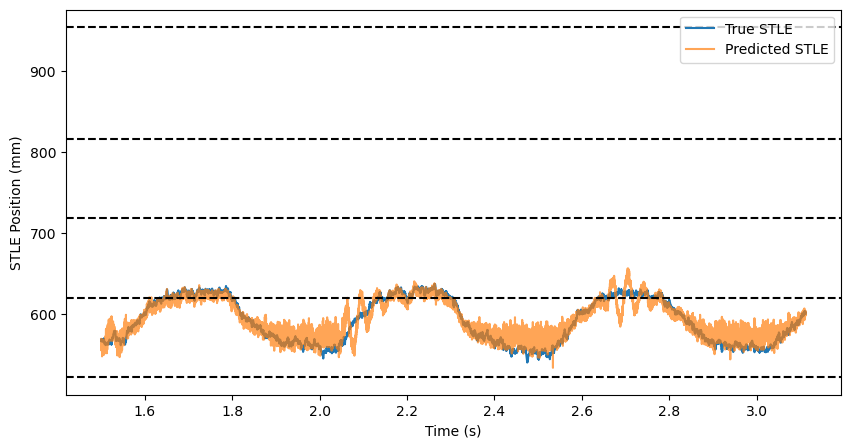

In [57]:
plt.figure(figsize=(10,5))
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_test,label='True STLE')
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_pred,label='Predicted STLE',alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.legend()
for i in location_list:
    plt.axhline(y=R17_w_time[i].iloc[0], color='black', linestyle='--')
plt.show()

Yes, it has the same pattern in the training set. What about other runs? How do they work? Let's automate the process of modeling and plot our expectations.

In [58]:
pressure_transducers = ['p1','p2','p3','p4','p5']

In [59]:
num_list = [i for i in range(0,38)]
num_list.remove(16)
num = 0

test_average_score = []
test_average_MSE = []

for i in df_list:
    train = i[i['time'] < 1.5]
    test = i[i['time'] >= 1.5]

    X_train = train.drop(['x1','Run','time'],axis=1)
    y_train = train['x1']
    X_test = test.drop(['x1','Run','time'],axis=1)
    y_test = test['x1']
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)
    y_pred = lin_reg.predict(X_test)
    y_pred_train = lin_reg.predict(X_train)
    
    test_average_score.append(lin_reg.score(X_test,y_test))
    test_average_MSE.append(mean_squared_error(y_test, y_pred))
    
lin_reg_summary = pd.DataFrame(data = {'Test Avg. Score Per Run':test_average_score,
                                              'Test Avg. MSE Per Run':test_average_MSE},
                              index = data['Run'].unique())

In [60]:
lin_reg_summary.sort_values(by='Test Avg. Score Per Run').head(5)

,Test Avg. Score Per Run,Test Avg. MSE Per Run
R17,0.479850,69.024311
R15,0.591773,99.165685
R26,0.666655,461.609230
R13,0.814498,67.875247
R14,0.828738,130.182324


In [61]:
lin_reg_summary.sort_values(by='Test Avg. MSE Per Run').head(5)

,Test Avg. Score Per Run,Test Avg. MSE Per Run
R6,0.963186,10.614106
R4,0.991621,13.691828
R0,0.997256,17.901037
R2,0.993674,18.502994
R3,0.995713,21.501810


In [64]:
num_list = [i for i in range(0,38)]
num_list.remove(16)
num = 0
for i in df_list:
    train = i[i['time'] < 1.5]
    test = i[i['time'] >= 1.5]

    X_train = train.drop(['x1','Run','time'],axis=1)
    y_train = train['x1']
    X_test = test.drop(['x1','Run','time'],axis=1)
    y_test = test['x1']
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)
    y_pred = lin_reg.predict(X_test)
    y_pred_train = lin_reg.predict(X_train)
    
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(30,20),sharex=False)
    
    plt.suptitle(f"Run R{num_list[num]}", fontsize=35)
    
    axes[0].plot(R17_w_time.iloc[y_train.index]['time'].sort_values(),y_train,label='True STLE')
    axes[0].plot(R17_w_time.iloc[y_train.index]['time'].sort_values(),y_pred_train,label='Predicted STLE',alpha=0.8)
    axes[0].set_title('Predicted vs. Actual')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('STLE Location')
    axes[0].legend()

    axes[1].plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_test,label='True STLE')
    axes[1].plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_pred,label='Predicted STLE',alpha=0.8)
    axes[1].set_title('Predicted vs. Actual')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('STLE Location')
    axes[1].legend()


    for j in pressure_transducers:
        axes[2].plot(i['time'],i[j],label=j)
        axes[2].legend()

    axes[2].set_title('Time vs. Pressure At Different Transducer Locations')
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Pressure')
    
    for k in location_list:
        axes[0].axhline(y=k, color='black', linestyle='--')
        axes[1].axhline(y=k, color='black', linestyle='--')
    
    #fig.savefig(f"../code/figures/Linear Regression/predicted vs actual/figure_R{num_list[num]}.png")
    num += 1
    #plt.close(fig)

# ANN

In [91]:
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import load_model

In [92]:
# Data Prep
train = R17_w_time[R17_w_time['time'] < 1.5]
test = R17_w_time[R17_w_time['time'] >= 1.5]

X_train = train.drop(['x1','time'],axis=1)
y_train = train['x1']
X_test = test.drop(['x1','time'],axis=1)
y_test = test['x1']

In [93]:
model = Sequential()

model.add(Dense(30,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(10,activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [94]:
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=100,epochs=100)

Epoch 1/100
150/150 [==============================] - 0s 1ms/step - loss: 24133.6172 - val_loss: 241.9186
Epoch 2/100
150/150 [==============================] - 0s 726us/step - loss: 247.2855 - val_loss: 256.9007
Epoch 3/100
150/150 [==============================] - 0s 731us/step - loss: 246.9475 - val_loss: 236.4628
Epoch 4/100
150/150 [==============================] - 0s 736us/step - loss: 246.5852 - val_loss: 258.1948
Epoch 5/100
150/150 [==============================] - 0s 766us/step - loss: 246.5420 - val_loss: 263.7194
Epoch 6/100
150/150 [==============================] - 0s 753us/step - loss: 245.9625 - val_loss: 249.4376
Epoch 7/100
150/150 [==============================] - 0s 794us/step - loss: 245.3807 - val_loss: 225.3062
Epoch 8/100
150/150 [==============================] - 0s 958us/step - loss: 245.5396 - val_loss: 238.3976
Epoch 9/100
150/150 [==============================] - 0s 826us/step - loss: 243.8420 - val_loss: 248.0100
Epoch 10/100
150/150 [===============

150/150 [==============================] - 0s 823us/step - loss: 79.4146 - val_loss: 42.4408
Epoch 78/100
150/150 [==============================] - 0s 825us/step - loss: 76.6850 - val_loss: 46.9017
Epoch 79/100
150/150 [==============================] - 0s 895us/step - loss: 76.7604 - val_loss: 51.4771
Epoch 80/100
150/150 [==============================] - 0s 840us/step - loss: 75.6208 - val_loss: 41.4614
Epoch 81/100
150/150 [==============================] - 0s 847us/step - loss: 76.8057 - val_loss: 79.8663
Epoch 82/100
150/150 [==============================] - 0s 850us/step - loss: 79.3784 - val_loss: 48.7605
Epoch 83/100
150/150 [==============================] - 0s 840us/step - loss: 73.9595 - val_loss: 45.4848
Epoch 84/100
150/150 [==============================] - 0s 837us/step - loss: 77.1444 - val_loss: 40.4356
Epoch 85/100
150/150 [==============================] - 0s 830us/step - loss: 73.8364 - val_loss: 76.4368
Epoch 86/100
150/150 [==============================] - 0s 

In [95]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

469/469 [==============================] - 0s 258us/step


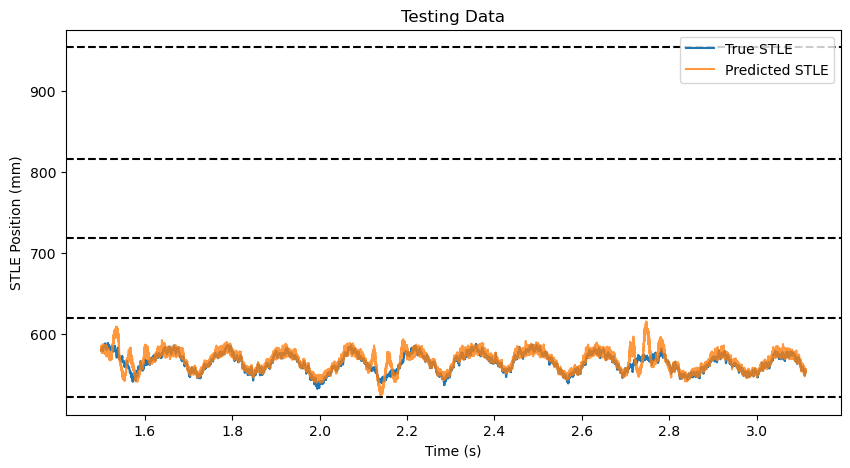

In [96]:
plt.figure(figsize=(10,5))
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_test,label='True STLE')
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_pred,label='Predicted STLE',alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.title('Testing Data')
plt.legend()

for i in location_list:
    plt.axhline(y=R17_w_time[i].iloc[0], color='black', linestyle='--')
    
plt.show()

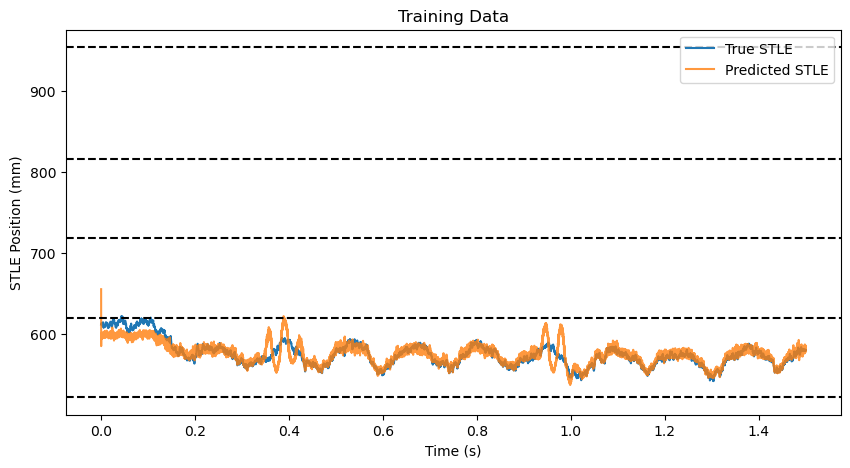

In [98]:
plt.figure(figsize=(10,5))
plt.plot(R17_w_time.iloc[y_train.index]['time'].sort_values(),y_train,label='True STLE')
plt.plot(R17_w_time.iloc[y_train.index]['time'].sort_values(),y_pred_train,label='Predicted STLE',alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.title('Training Data')
plt.legend()

for i in location_list:
    plt.axhline(y=R17_w_time[i].iloc[0], color='black', linestyle='--')

plt.show()

# RNN (R17)

In [99]:
# Data Prep
train = R17_w_time[R17_w_time['time'] < 1.5]
test = R17_w_time[R17_w_time['time'] >= 1.5]

X_train = train.drop(['x1','time'],axis=1)
y_train = train['x1']
X_test = test.drop(['x1','time'],axis=1)
y_test = test['x1']

In [100]:
model = Sequential()

model.add(LSTM(50,activation='relu', input_shape=[None,1], return_sequences=True))
model.add(LSTM(50,activation='relu', input_shape=[None,1], return_sequences=True))
model.add(LSTM(50,activation='relu', input_shape=[None,1], return_sequences=True))
model.add(LSTM(50,activation='relu', input_shape=[None,1]))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [101]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=100,epochs=100,callbacks=[early_stopping])

Epoch 1/100
150/150 [==============================] - 4s 23ms/step - loss: 22424.2930 - val_loss: 112.5290
Epoch 2/100
150/150 [==============================] - 4s 24ms/step - loss: 90.5460 - val_loss: 83.9024
Epoch 3/100
150/150 [==============================] - 4s 24ms/step - loss: 93.3212 - val_loss: 93.0497
Epoch 4/100
150/150 [==============================] - 4s 24ms/step - loss: 85.5178 - val_loss: 79.4552
Epoch 5/100
150/150 [==============================] - 4s 24ms/step - loss: 82.1992 - val_loss: 125.9722
Epoch 6/100
150/150 [==============================] - 3s 22ms/step - loss: 84.2888 - val_loss: 67.3410
Epoch 7/100
150/150 [==============================] - 3s 21ms/step - loss: 92.1362 - val_loss: 115.0350
Epoch 8/100
150/150 [==============================] - 3s 21ms/step - loss: 97.1786 - val_loss: 83.9151
Epoch 9/100
150/150 [==============================] - 3s 21ms/step - loss: 85.4177 - val_loss: 75.4686
Epoch 10/100
150/150 [==============================] - 3s

In [102]:
y_pred = model.predict(X_test).flatten()
y_pred_train = model.predict(X_train).flatten()

469/469 [==============================] - 1s 2ms/step


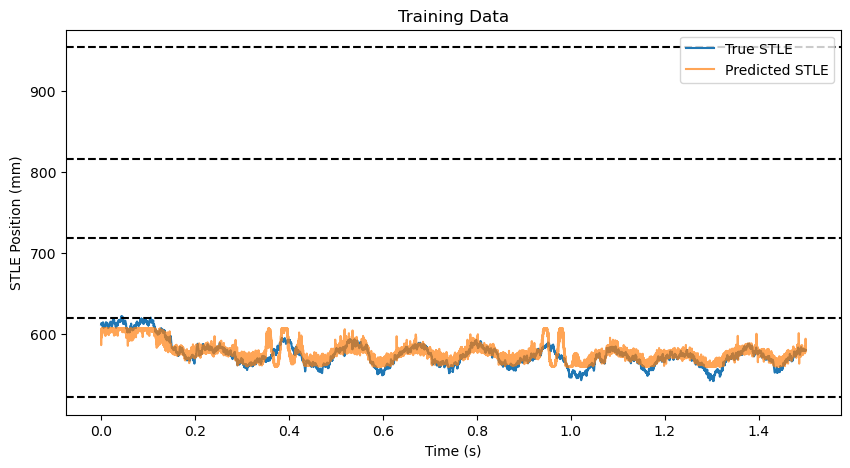

In [105]:
plt.figure(figsize=(10,5))
plt.plot(R17_w_time.iloc[y_train.index]['time'].sort_values(),y_train,label='True STLE')
plt.plot(R17_w_time.iloc[y_train.index]['time'].sort_values(),y_pred_train,label='Predicted STLE',alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.title('Training Data')
plt.legend()

for i in location_list:
    plt.axhline(y=R17_w_time[i].iloc[0], color='black', linestyle='--')

plt.show()

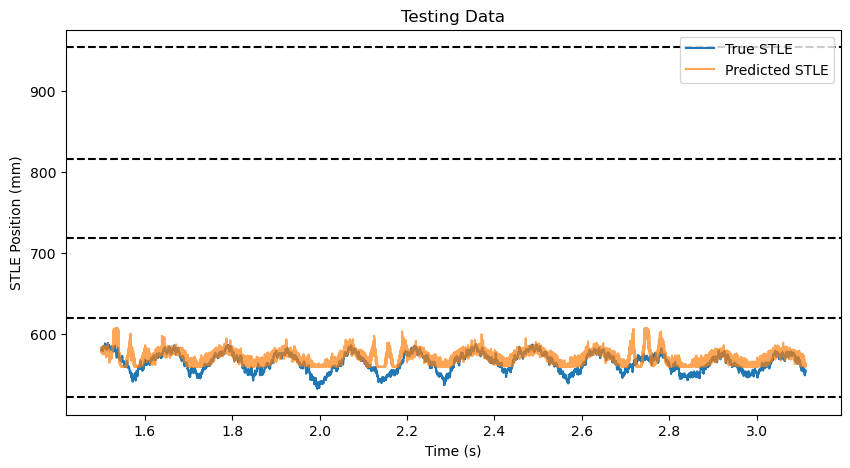

In [106]:
plt.figure(figsize=(10,5))
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_test,label='True STLE')
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_pred,label='Predicted STLE',alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.title('Testing Data')
plt.legend()

for i in location_list:
    plt.axhline(y=R17_w_time[i].iloc[0], color='black', linestyle='--')


plt.show()

# Test Case on R26 (RNN)

In [1087]:
# Data Prep
train = R26[R26['time'] < 2.5]
test = R26[R26['time'] >= 2.5]

X_train = train.drop(['x1','time','Run'],axis=1)
y_train = train['x1']
X_test = test.drop(['x1','time','Run'],axis=1)
y_test = test['x1']

In [1088]:
model = Sequential()

model.add(LSTM(20,activation='relu', input_shape=[None,1], return_sequences=True))
model.add(LSTM(20,activation='relu', input_shape=[None,1], return_sequences=True))
model.add(LSTM(20,activation='relu', input_shape=[None,1], return_sequences=True))
model.add(LSTM(20,activation='relu', input_shape=[None,1], return_sequences=True))
model.add(LSTM(20,activation='relu', input_shape=[None,1], return_sequences=True))
model.add(LSTM(10,activation='relu', input_shape=[None,1]))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [1089]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=100,epochs=100,callbacks=[early_stopping])

Epoch 1/100
250/250 [==============================] - 3s 6ms/step - loss: 92892.4375 - val_loss: 195.9788
Epoch 2/100
250/250 [==============================] - 1s 5ms/step - loss: 92.1026 - val_loss: 66.1450
Epoch 3/100
250/250 [==============================] - 1s 5ms/step - loss: 58.7892 - val_loss: 62.5211
Epoch 4/100
250/250 [==============================] - 1s 5ms/step - loss: 51.0751 - val_loss: 54.0462
Epoch 5/100
250/250 [==============================] - 1s 5ms/step - loss: 48.9372 - val_loss: 45.8079
Epoch 6/100
250/250 [==============================] - 1s 5ms/step - loss: 44.4548 - val_loss: 45.7493
Epoch 7/100
250/250 [==============================] - 1s 5ms/step - loss: 43.4356 - val_loss: 36.5905
Epoch 8/100
250/250 [==============================] - 1s 6ms/step - loss: 42.2374 - val_loss: 31.3448
Epoch 9/100
250/250 [==============================] - 1s 5ms/step - loss: 45.8245 - val_loss: 32.0797
Epoch 10/100
250/250 [==============================] - 1s 5ms/step -

In [1061]:
y_pred = model.predict(X_test).flatten()
y_pred_train = model.predict(X_train).flatten()

782/782 [==============================] - 1s 1ms/step


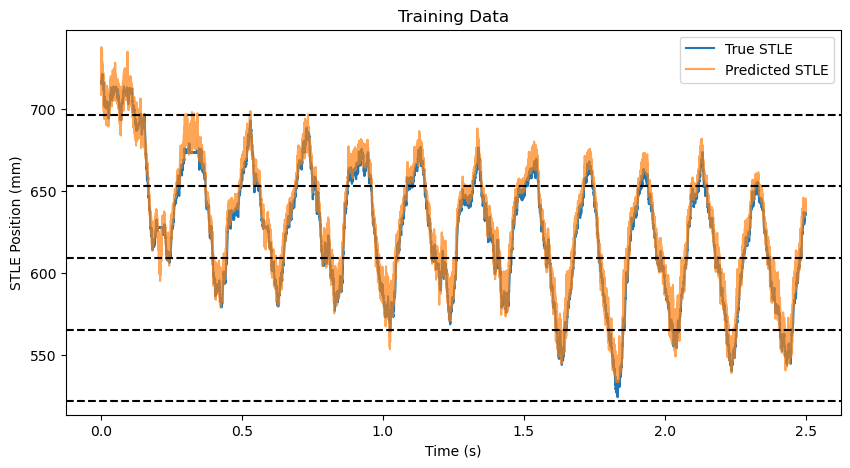

In [1062]:
plt.figure(figsize=(10,5))
plt.plot(R17_w_time.iloc[y_train.index]['time'].sort_values(),y_train,label='True STLE')
plt.plot(R17_w_time.iloc[y_train.index]['time'].sort_values(),y_pred_train,label='Predicted STLE',alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.title('Training Data')
plt.legend()

for i in location_list:
    plt.axhline(y=i, color='black', linestyle='--')

plt.show()

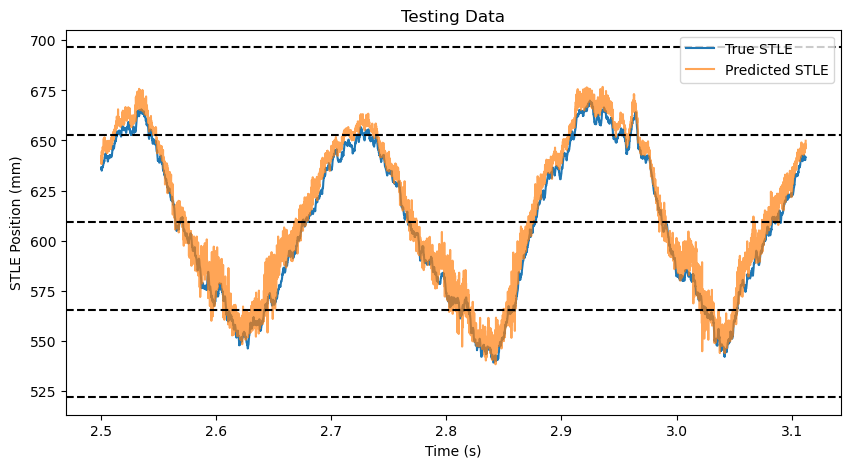

In [1063]:
plt.figure(figsize=(10,5))
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_test,label='True STLE')
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_pred,label='Predicted STLE',alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.title('Testing Data')
plt.legend()

for i in location_list:
    plt.axhline(y=i, color='black', linestyle='--')


plt.show()

# Test Case on R14 (RNN)

In [1122]:
R14_w_time = R14.copy().drop('Run',axis=1)

train = R14_w_time[R14_w_time['time'] < 1.5]
test = R14_w_time[R14_w_time['time'] >= 1.5]

X_train = train.drop('x1',axis=1)
y_train = train['x1']
X_test = test.drop('x1',axis=1)
y_test = test['x1']

In [1528]:
model = Sequential()

model.add(SimpleRNN(20,activation='relu', input_shape=[None,1], return_sequences=True))
model.add(SimpleRNN(20,activation='relu', input_shape=[None,1], return_sequences=True))
model.add(SimpleRNN(20,activation='relu', input_shape=[None,1], return_sequences=True))
model.add(SimpleRNN(20,activation='relu', input_shape=[None,1], return_sequences=True))
model.add(SimpleRNN(20,activation='relu', input_shape=[None,1]))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [1529]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=100,epochs=100,callbacks=[early_stopping])

Epoch 1/100
147/147 [==============================] - 2s 8ms/step - loss: 90793.9766 - val_loss: 25819.4121
Epoch 2/100
147/147 [==============================] - 1s 7ms/step - loss: 1328.8123 - val_loss: 3435.2131
Epoch 3/100
147/147 [==============================] - 1s 7ms/step - loss: 214.3259 - val_loss: 1664.0518
Epoch 4/100
147/147 [==============================] - 1s 7ms/step - loss: 145.8653 - val_loss: 1272.1815
Epoch 5/100
147/147 [==============================] - 1s 7ms/step - loss: 107.1947 - val_loss: 1213.2659
Epoch 6/100
147/147 [==============================] - 1s 8ms/step - loss: 90.3246 - val_loss: 719.2806
Epoch 7/100
147/147 [==============================] - 1s 7ms/step - loss: 74.5422 - val_loss: 686.8820
Epoch 8/100
147/147 [==============================] - 1s 7ms/step - loss: 62.9148 - val_loss: 713.6760
Epoch 9/100
147/147 [==============================] - 1s 7ms/step - loss: 57.7368 - val_loss: 712.7373
Epoch 10/100
147/147 [============================

In [1530]:
y_pred = model.predict(X_test).flatten()
y_pred_train = model.predict(X_train).flatten()

460/460 [==============================] - 1s 1ms/step


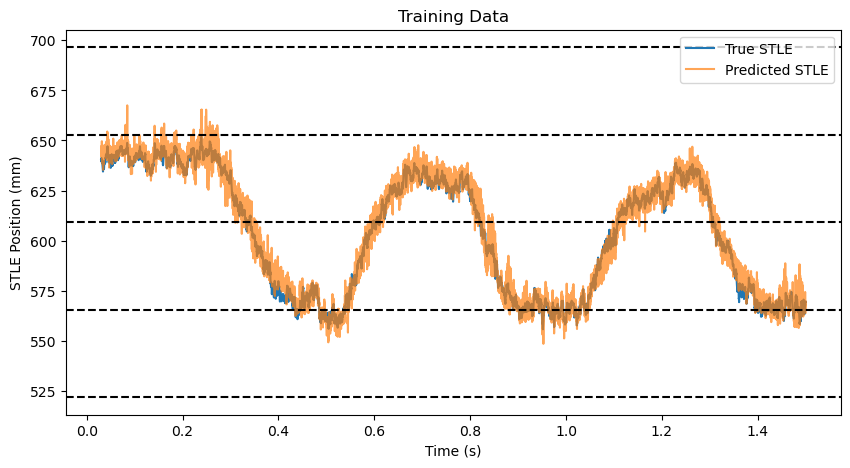

In [1531]:
plt.figure(figsize=(10,5))
plt.plot(R14_w_time.iloc[y_train.index]['time'].sort_values(),y_train,label='True STLE')
plt.plot(R14_w_time.iloc[y_train.index]['time'].sort_values(),y_pred_train,label='Predicted STLE',alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.title('Training Data')
plt.legend()

for i in location_list:
    plt.axhline(y=i, color='black', linestyle='--')

plt.show()

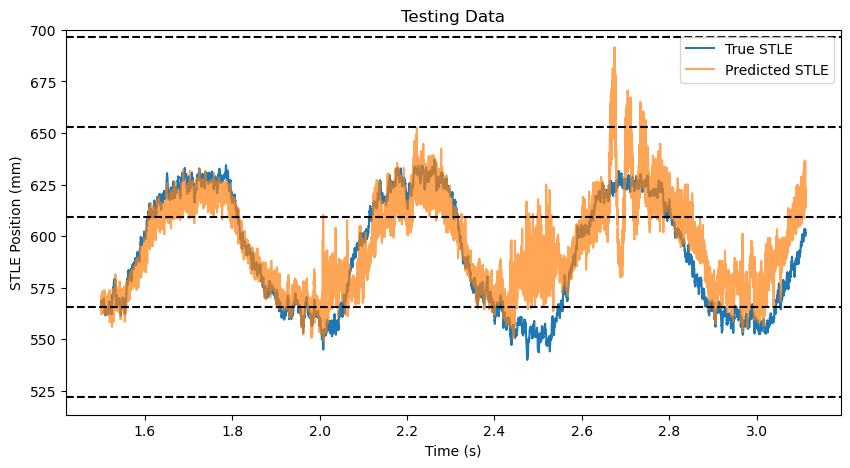

In [1532]:
plt.figure(figsize=(10,5))
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_test,label='True STLE')
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_pred,label='Predicted STLE',alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.title('Testing Data')
plt.legend()

for i in location_list:
    plt.axhline(y=i, color='black', linestyle='--')


plt.show()

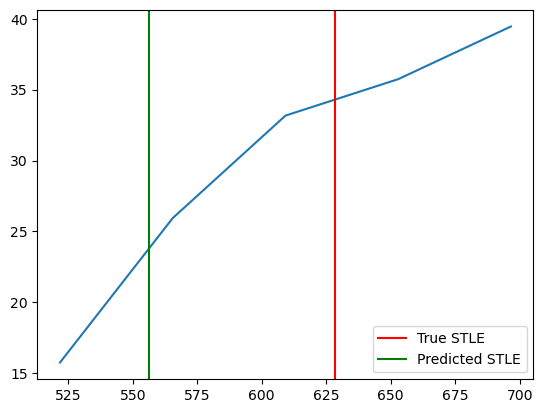

In [1143]:
plt.plot([px1,px2,px3,px4,px5],R14.iloc[26871].loc['p1':'p5'])
plt.axvline(x=R14.iloc[26871]['x1'], color='red',label='True STLE')
plt.axvline(x=y_pred[np.abs(y_pred - y_test).argmax()], color='green',label='Predicted STLE')
plt.legend()

# Adding Previous Pressure Method

In [1176]:
R17_p = R17.copy()

In [1175]:
R17_p['p1'].rolling(200).mean()

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
31118    15.636054
31119    15.654565
31120    15.671703
31121    15.685164
31122    15.700526
Name: p1, Length: 31123, dtype: float64

(2.0, 2.2)

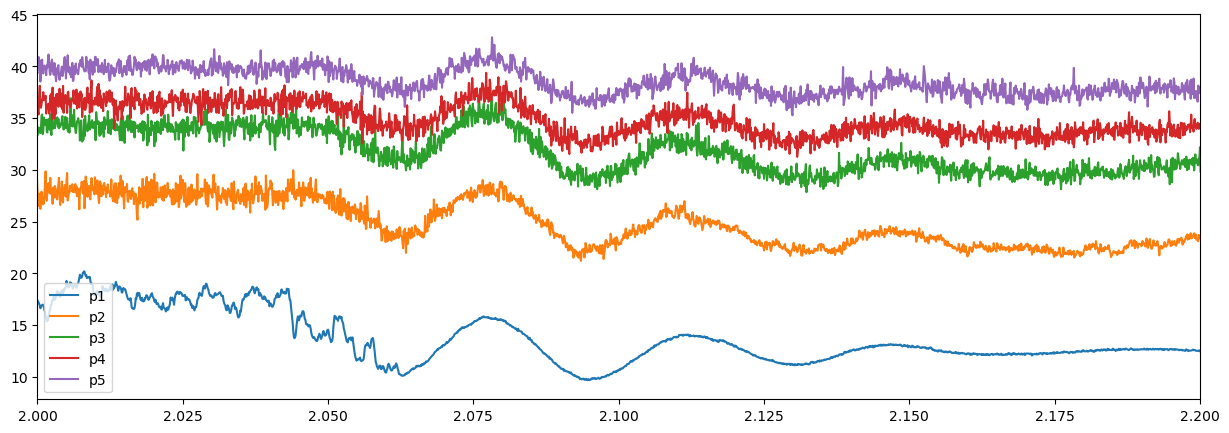

In [1241]:
plt.figure(figsize=(15,5))

for j in pressure_transducers:
    plt.plot(R14['time'],R14[j],label=j)
    plt.legend()
    
plt.xlim(2.0,2.2)
    

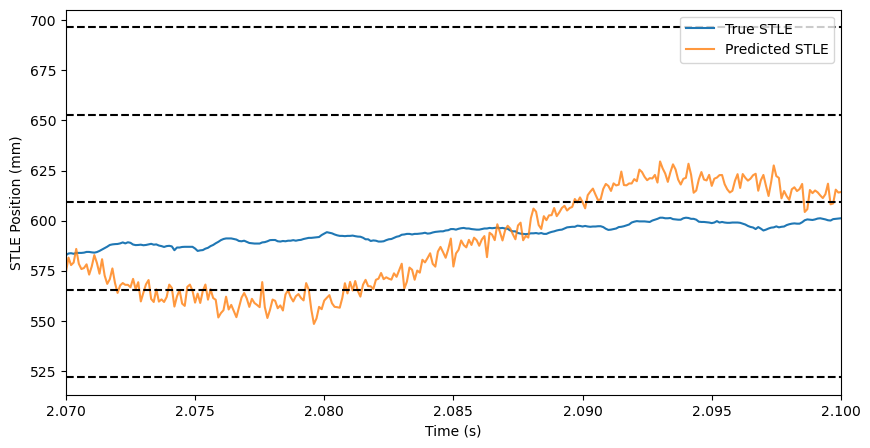

In [1280]:
R14_w_time = R14.copy().drop('Run',axis=1)

train = R14_w_time[R17_w_time['time'] < 1.5]
test = R14_w_time[R17_w_time['time'] >= 1.5]

X_train = train.drop('x1',axis=1)
y_train = train['x1']
X_test = test.drop('x1',axis=1)
y_test = test['x1']
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)
y_pred_train = lin_reg.predict(X_train)

plt.figure(figsize=(10,5))
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_test,label='True STLE')
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_pred,label='Predicted STLE',alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.legend()

for i in location_list:
    plt.axhline(y=i, color='black', linestyle='--')
    
plt.xlim(2.070,2.1)
plt.show()

In [1282]:
R14.iloc[20700]

p1       13.026128
p2       26.344915
p3       33.645132
p4       36.660478
p5       39.215829
x1      582.738854
Run            R14
time          2.07
Name: 20700, dtype: object

In [1287]:
R14.iloc[20950]

p1        9.690148
p2       22.763117
p3       28.665472
p4       32.861651
p5       37.109529
x1      598.761314
Run            R14
time         2.095
Name: 20950, dtype: object

# Rolling Averages

In [111]:
R17_roll = R17.copy()

window = 300

R17_roll['p1_roll'] = R17['p1'].rolling(window).mean()
R17_roll['p2_roll'] = R17['p2'].rolling(window).mean()
R17_roll['p3_roll'] = R17['p3'].rolling(window).mean()
R17_roll['p4_roll'] = R17['p4'].rolling(window).mean()
R17_roll['p5_roll'] = R17['p5'].rolling(window).mean()
R17_roll['p1_roll'] = R17['p1'].rolling(window).median()
R17_roll['p2_roll'] = R17['p2'].rolling(window).median()
R17_roll['p3_roll'] = R17['p3'].rolling(window).median()
R17_roll['p4_roll'] = R17['p4'].rolling(window).median()
R17_roll['p5_roll'] = R17['p5'].rolling(window).median()

In [112]:
R17_roll = R17_roll.iloc[window:]

In [113]:
from sklearn.linear_model import Lasso

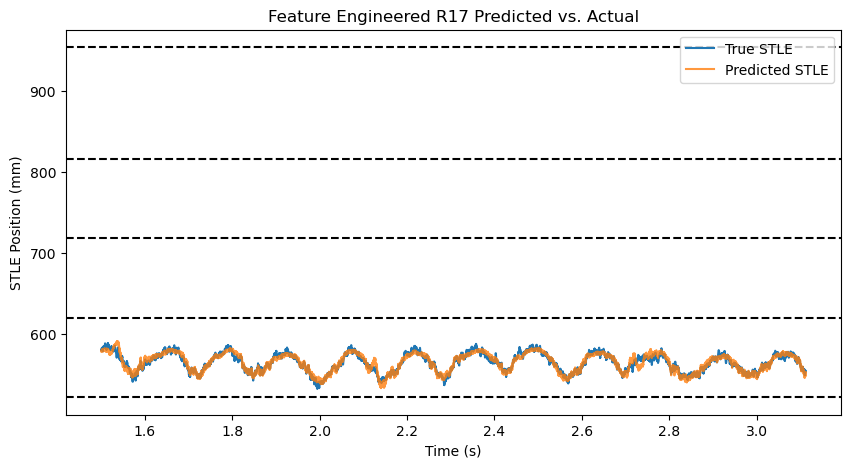

In [116]:
train = R17_roll[R17_roll['time'] < 1.5]
test = R17_roll[R17_roll['time'] >= 1.5]

X_train = train.drop(['x1','Run','time','px1','px2','px3','px4','px5'],axis=1)
y_train = train['x1']
X_test = test.drop(['x1','Run','time','px1','px2','px3','px4','px5'],axis=1)
y_test = test['x1']
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)
y_pred_train = lin_reg.predict(X_train)

plt.figure(figsize=(10,5))
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_test,label='True STLE')
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_pred,label='Predicted STLE',alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.legend()

for i in location_list:
    plt.axhline(y=R17_w_time[i].iloc[0], color='black', linestyle='--')

plt.title('Feature Engineered R17 Predicted vs. Actual')

plt.savefig('../code/figures/plot_for_pres/R17PredictedvsActualFeaturEngineered.png')

plt.show()

In [117]:
mean_squared_error(y_test, y_pred)

14.27252586153068

In [118]:
def roll_average(df,window):
    df_roll = df.copy()

    df_roll['p1_roll'] = df['p1'].rolling(window).mean()
    df_roll['p2_roll'] = df['p2'].rolling(window).mean()
    df_roll['p3_roll'] = df['p3'].rolling(window).mean()
    df_roll['p4_roll'] = df['p4'].rolling(window).mean()
    df_roll['p5_roll'] = df['p5'].rolling(window).mean()
    df_roll['p1_roll_sd'] = df['p1'].rolling(window).median()
    df_roll['p2_roll_sd'] = df['p2'].rolling(window).median()
    df_roll['p3_roll_sd'] = df['p3'].rolling(window).median()
    df_roll['p4_roll_sd'] = df['p4'].rolling(window).median()

    
    return  df_roll[window:]

In [119]:
from sklearn.linear_model import ElasticNet

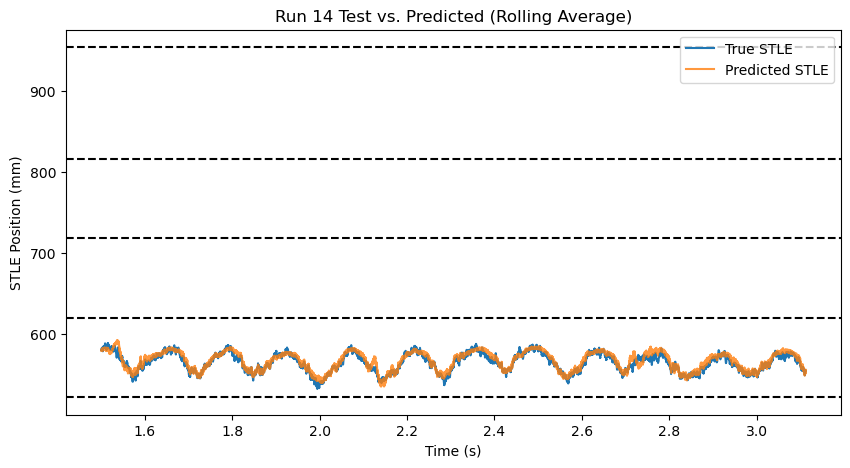

In [121]:
R14_roll = roll_average(R14, 300)

train = R17_roll[R17_roll['time'] < 1.5]
test = R17_roll[R17_roll['time'] >= 1.5]

ss = StandardScaler()

X_train = ss.fit_transform(train.drop(['x1','Run'],axis=1))
y_train = train['x1']
X_test = ss.transform(test.drop(['x1','Run'],axis=1))
y_test = test['x1']
rid_reg = Ridge(alpha=0.1)
rid_reg.fit(X_train,y_train)
y_pred = rid_reg.predict(X_test)
y_pred_train = rid_reg.predict(X_train)

plt.figure(figsize=(10,5))
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_test,label='True STLE')
plt.plot(R17_w_time.iloc[y_test.index]['time'].sort_values(),y_pred,label='Predicted STLE',alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('STLE Position (mm)')
plt.legend()

for i in location_list:
    plt.axhline(y=R14[i].iloc[0], color='black', linestyle='--')
    
plt.title('Run 14 Test vs. Predicted (Rolling Average)')

plt.show()

In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet

Using rolling averages improved the scores of our model. Hence, we will proceed to build a model that could predict different Runs simutaneously.